# Imports

In [29]:
import pandas as pd 
import numpy  as np

import matplotlib.pyplot as plt
import seaborn           as sns 

import yfinance          as yf
import talib

from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier

# Loading Data

In [30]:
ibov_df =  yf.download('^BVSP', interval='1d', period = '5y')

[*********************100%***********************]  1 of 1 completed


In [31]:
ibov_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-18,53229.0,53479.0,52305.0,52894.0,52894.0,4385600
2016-04-19,52894.0,54054.0,52894.0,53710.0,53710.0,5033900
2016-04-20,53711.0,53857.0,53149.0,53631.0,53631.0,4554100
2016-04-22,53630.0,53630.0,52629.0,52908.0,52908.0,4259400
2016-04-25,52911.0,52949.0,51748.0,51862.0,51862.0,3693200


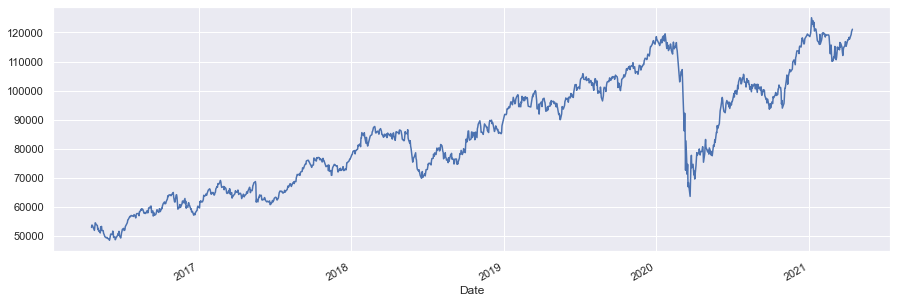

In [32]:
sns.set(rc={'figure.figsize':(15,5)})
ibov_df['Adj Close'].plot()

# Feature Engineering

In [33]:
# Bulding a Trend Intensity Indicator 
period = 60
sma = talib.SMA(ibov_df['Adj Close'].values,timeperiod=period)
ibov_df['statement'] = ibov_df['Adj Close'] > sma
ibov_df['tii'] = (ibov_df['statement'].rolling(period).sum())/period*100
ibov_df.drop(['statement'], axis=1, inplace=True)

# Low to Close sum last 10 periods
ibov_df['lowToCloseSum10p'] = ibov_df['Adj Close'] - ibov_df['Low'] 
ibov_df['lowToCloseSum10p'] = ibov_df['lowToCloseSum10p'].rolling(10).sum()

# 5 period Standard Deviation
ibov_df['std5p'] = ibov_df['Adj Close'].rolling(5).std()

# Create moving averages and rsi for timeperiods of 30, 50, and 200
for n in [30, 50, 200]:

    # Normalize the moving average dividing by the Adj Close
    ibov_df['ma' + str(n)] = talib.SMA(ibov_df['Adj Close'].values,
                              timeperiod=n) / ibov_df['Adj Close']
    # Create the RSI indicator
    ibov_df['rsi' + str(n)] = talib.RSI(ibov_df['Adj Close'].values, timeperiod=n)
    
# Drop nan
ibov_df.dropna(inplace=True)

In [34]:
ibov_df.head(2)

,Open,High,Low,Close,Adj Close,Volume,tii,lowToCloseSum10p,std5p,ma30,rsi30,ma50,rsi50,ma200,rsi200
Date,,,,,,,,,,,,,,,
2017-02-02,64835.0,65132.0,64163.0,64578.0,64578.0,2959200,60.0,4016.0,671.292187,0.967195,57.184541,0.952634,55.865885,0.890868,54.782566
2017-02-03,64579.0,65387.0,64264.0,64954.0,64954.0,3482700,60.0,4329.0,251.040236,0.965346,58.088644,0.948033,56.404813,0.886576,54.922019


# Data Preparation

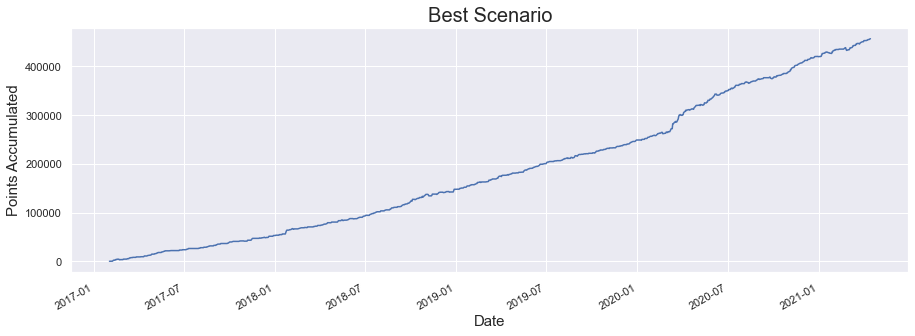

In [52]:
# Creating Y to predict
ibov_df['y'] = np.where(ibov_df['High'] - ibov_df['Open'] > 700, 1,0)
ibov_df['y'] = ibov_df['y'].shift(-1)
ibov_df['Variation'] = (ibov_df['Adj Close'] - ibov_df['Open']).shift(-1)
ibov_df['Perfect_y'] = ibov_df['y'] * ibov_df['Variation']
ibov_df['Perfect_y_accum'] = ibov_df['Perfect_y'].cumsum()

# Drop nan
ibov_df.dropna(inplace=True)

# Plot Best scenario 
ibov_df['Perfect_y_accum'].plot()
plt.xlabel('Date', fontsize=15)
plt.ylabel('Points Accumulated', fontsize=15)
plt.title('Best Scenario', fontsize=20)
plt.show()

In [36]:
# Statistics
ibov_df[['y', 'Variation']].groupby('y').count()

,Variation
y,
0.0,533
1.0,501


In [37]:
# Split Features and Target
df_features = ibov_df[['Open', 'High', 'Low','Adj Close', 'Volume', 'tii', 'lowToCloseSum10p', 
               'std5p', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']].copy()
df_target   = ibov_df['y'].copy()

# Create a size for the training set 
train_size = int(0.75 * df_target.shape[0])

X_train = df_features[:train_size]
y_train = df_target[:train_size]
X_test  = df_features[train_size:]
y_test  = df_target[train_size:]
print('df_features shape: ', df_features.shape)
print('df_target shape: ', df_target.shape)

df_features shape:  (1034, 14)
df_target shape:  (1034,)


# Model Training - Random Forest

In [38]:
# Hyperparameters to search
grid = {'max_depth': [*range(2,11)], 'max_features': [*range(3,11)], 'random_state': [42]}

# Find the best hyperparameters
rfr = RandomForestClassifier(n_estimators=200)
ts = TimeSeriesSplit(n_splits=4)
clf = GridSearchCV(estimator=rfr, cv=ts, param_grid=grid)
clf.fit(X_train, y_train)

print("Tuned Random Forest Regression Parameters: {}".format(clf.best_params_)) 
print("Best score is {}".format(clf.best_score_))

Tuned Random Forest Regression Parameters: {'max_depth': 2, 'max_features': 9, 'random_state': 42}
Best score is 0.5951612903225807


# Performance Metrics - Random Forest

In [39]:
# Results
randfor_pred = clf.predict(X_test)
print("R2: {}".format(clf.score(X_test, y_test)))
print()
print(pd.crosstab(y_test, randfor_pred))
print()
print(classification_report(y_test, randfor_pred))

R2: 0.5405405405405406

col_0  0.0  1.0
y              
0.0     30   62
1.0     57  110

              precision    recall  f1-score   support

         0.0       0.34      0.33      0.34        92
         1.0       0.64      0.66      0.65       167

    accuracy                           0.54       259
   macro avg       0.49      0.49      0.49       259
weighted avg       0.53      0.54      0.54       259



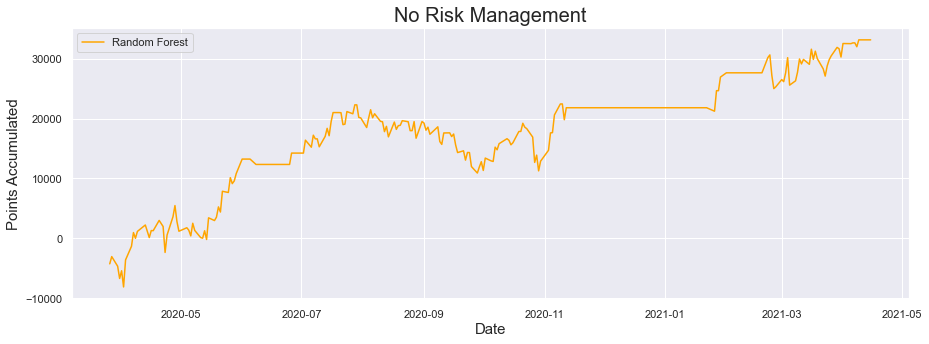

In [40]:
avaliation_df = ibov_df[['Open', 'High', 'Adj Close', 'y', 'Variation']][train_size:]
avaliation_df['Perfect_y_accum'] = (avaliation_df['y'] * avaliation_df['Variation']).cumsum()
avaliation_df['RandFor_y'] = randfor_pred
avaliation_df['RandFor_Result'] = avaliation_df['RandFor_y'] * avaliation_df['Variation']
avaliation_df['RandFor_Result_accum'] = avaliation_df['RandFor_Result'].cumsum()

#plt.plot(avaliation_df['Perfect_y_accum'], color = 'darkblue', label= 'Best Cenary')
plt.plot(avaliation_df['RandFor_Result_accum'], color = 'orange', label= 'Random Forest')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Points Accumulated', fontsize=15)
plt.title('No Risk Management', fontsize=20)
plt.legend()
plt.show()

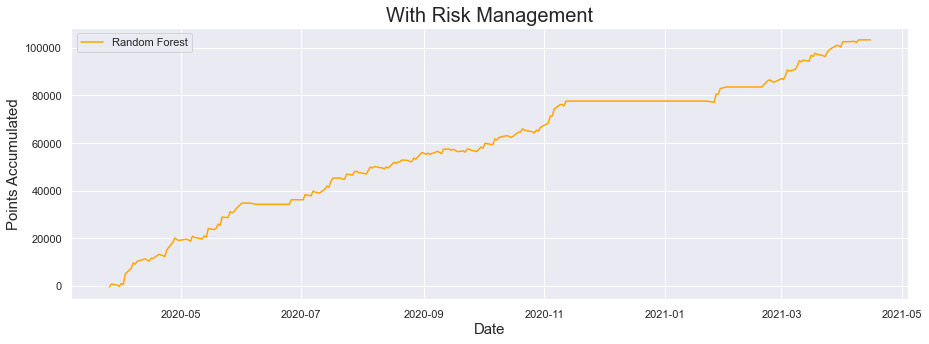

In [41]:
avaliation_df = ibov_df[['Open', 'High', 'Adj Close', 'y', 'Variation']][train_size:]
avaliation_df['Perfect_y_accum'] = (avaliation_df['y'] * avaliation_df['Variation']).cumsum()

avaliation_df['RandFor_y'] = randfor_pred
avaliation_df['RandFor_Result'] = np.where(avaliation_df['RandFor_y'] * avaliation_df['Variation'] < -500, -500,avaliation_df['RandFor_y'] * avaliation_df['Variation'])
avaliation_df['RandFor_Result_accum'] = avaliation_df['RandFor_Result'].cumsum()

#plt.plot(avaliation_df['Perfect_y_accum'], color = 'darkblue', label= 'Best Cenary')
plt.plot(avaliation_df['RandFor_Result_accum'], color = 'orange', label= 'Random Forest')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Points Accumulated', fontsize=15)
plt.title('With Risk Management', fontsize=20)
plt.legend()
plt.show()

# Model Training - Support Vector Machine

In [42]:
# SVM Model
svm = SVC(kernel = 'rbf',gamma='scale')
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)

# Performance Metrics - Support Vector Machine

In [43]:
# Results
print("R2: {}".format(svm.score(X_test, y_test)))
print()
print(pd.crosstab(y_test, svm_pred))
print()
print(classification_report(y_test, svm_pred))

R2: 0.640926640926641

col_0  0.0  1.0
y              
0.0      0   92
1.0      1  166

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        92
         1.0       0.64      0.99      0.78       167

    accuracy                           0.64       259
   macro avg       0.32      0.50      0.39       259
weighted avg       0.41      0.64      0.50       259



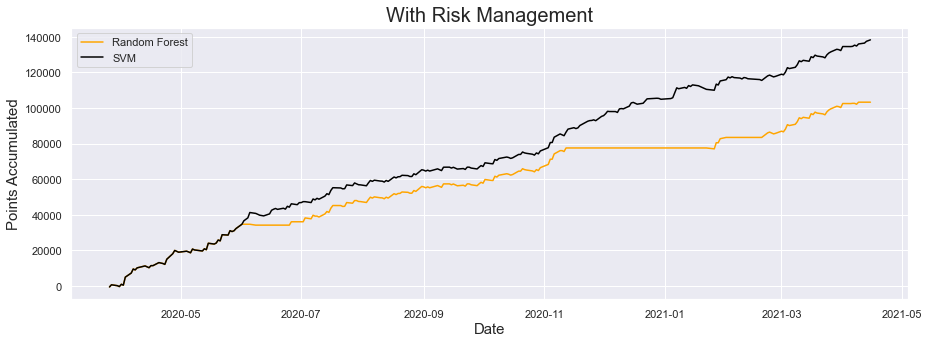

In [44]:
# Calculate metrics
avaliation_df['SVM_y'] = svm_pred
avaliation_df['SVM_Result'] =  np.where(avaliation_df['SVM_y'] * avaliation_df['Variation'] < -500, -500,avaliation_df['SVM_y'] * avaliation_df['Variation'])
avaliation_df['SVM_Result_accum'] = avaliation_df['SVM_Result'].cumsum()

# Plot Results
plt.plot(avaliation_df['RandFor_Result_accum'], color = 'orange', label= 'Random Forest')
plt.plot(avaliation_df['SVM_Result_accum'], color = 'black', label= 'SVM')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Points Accumulated', fontsize=15)
plt.title('With Risk Management', fontsize=20)
plt.legend()
plt.show()

# Model Training - KNN

In [45]:
# KNeighbors Classifier
param_grid = {'n_neighbors': [*range(5,11)]}
knn = KNeighborsClassifier()
ts = TimeSeriesSplit(n_splits=4)
clf = GridSearchCV(knn, param_grid, cv=ts)
clf.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10]})

# Performance Metrics - KNN 

In [46]:
# Results
knn_pred = clf.predict(X_test)
print("Tuned KNeighbors Classifier Parameters: {}".format(clf.best_params_)) 
print("Best score is {}".format(clf.best_score_))
print()
print(confusion_matrix(y_test, knn_pred))
print()
print(classification_report(y_test, knn_pred))

Tuned KNeighbors Classifier Parameters: {'n_neighbors': 8}
Best score is 0.5370967741935484

[[52 40]
 [80 87]]

              precision    recall  f1-score   support

         0.0       0.39      0.57      0.46        92
         1.0       0.69      0.52      0.59       167

    accuracy                           0.54       259
   macro avg       0.54      0.54      0.53       259
weighted avg       0.58      0.54      0.55       259



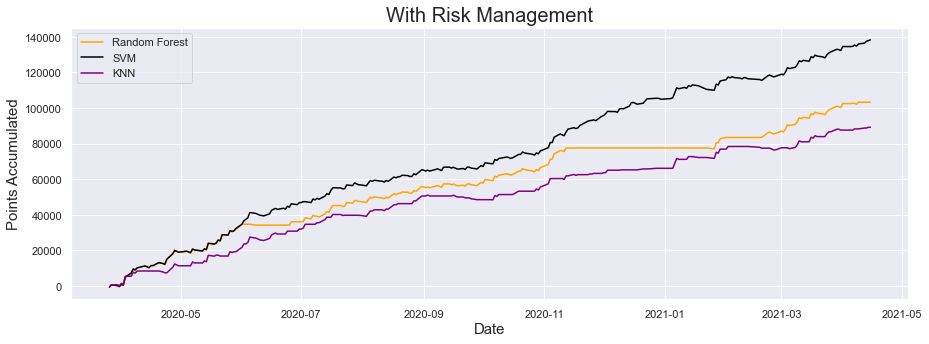

In [47]:
# Calculate metrics
avaliation_df['KNN_y'] = knn_pred
avaliation_df['KNN_Result'] =  np.where(avaliation_df['KNN_y'] * avaliation_df['Variation'] < -500, -500,avaliation_df['KNN_y'] * avaliation_df['Variation'])
avaliation_df['KNN_Result_accum'] = avaliation_df['KNN_Result'].cumsum()

# Plot Results
plt.plot(avaliation_df['RandFor_Result_accum'], color = 'orange', label= 'Random Forest')
plt.plot(avaliation_df['SVM_Result_accum'], color = 'black', label= 'SVM')
plt.plot(avaliation_df['KNN_Result_accum'], color = 'purple', label= 'KNN')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Points Accumulated', fontsize=15)
plt.title('With Risk Management', fontsize=20)
plt.legend()
plt.show()

# Evaluating the Best Model 

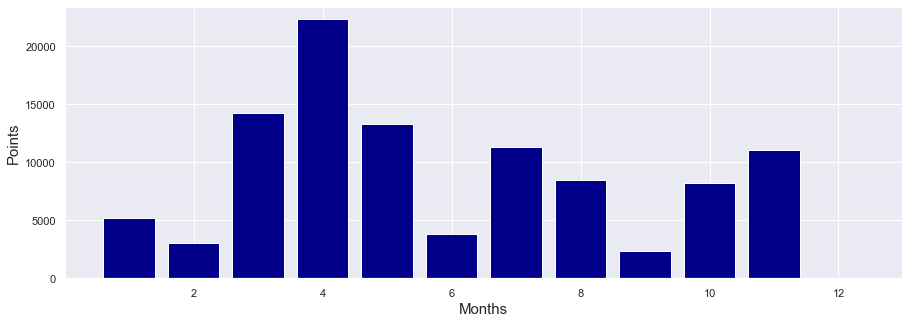

In [48]:
# Random Forest points per months
ibov_aval = avaliation_df.groupby(avaliation_df.index.month).sum()
plt.bar(ibov_aval.index, ibov_aval.RandFor_Result, color='darkblue')
plt.xlabel('Months', fontsize= 15)
plt.ylabel('Points', fontsize= 15)
plt.show()

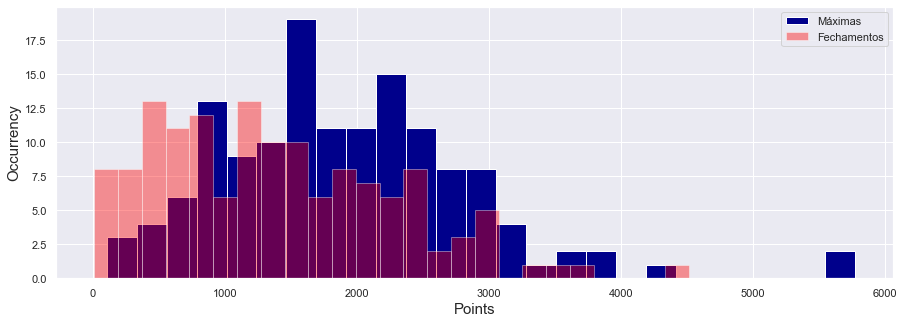

In [49]:
# Relationship between high of the day and close of the day
maior = avaliation_df[avaliation_df['Adj Close'] > avaliation_df['Open']]
plt.hist(maior['High'] - maior['Open'],bins = 25, label='Máximas', color='darkblue')
plt.hist(maior['Adj Close'] - maior['Open'],bins = 25, color='red', label='Fechamentos', alpha=0.4)
plt.legend()
plt.xlabel('Points', fontsize= 15)
plt.ylabel('Occurrency', fontsize= 15)
plt.show()

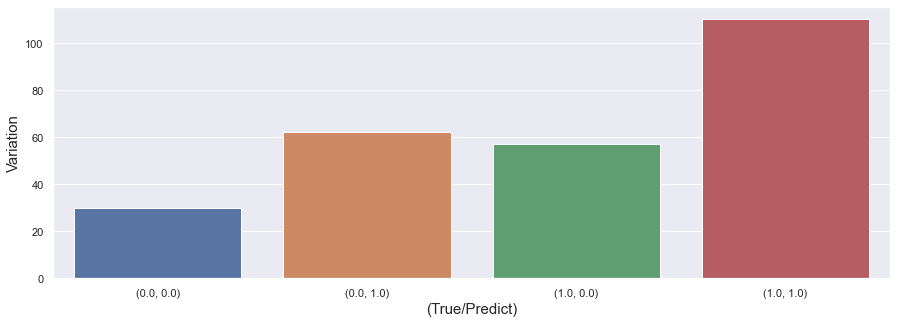

In [50]:
# Comparsion of True label and Predicted Label
barplot = avaliation_df.groupby(['y','RandFor_y']).count()
sns.barplot(barplot.index, barplot.Variation, data=barplot)
plt.xlabel('(True/Predict)', fontsize=15)
plt.ylabel('Variation', fontsize=15)
plt.show()

In [51]:
# Mean Loss and Mean Profit
mean_profit = avaliation_df[avaliation_df['RandFor_Result']>0]['RandFor_Result'].mean()
mean_loss   = avaliation_df[avaliation_df['RandFor_Result']<0]['RandFor_Result'].mean()

print('Mean Profit:', mean_profit)
print('Mean Loss:', mean_loss)

Mean Profit: 1533.611111111111
Mean Loss: -423.6707317073171
